<a href="https://colab.research.google.com/github/evamizer/to-be-or-not/blob/main/to-be-or-not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Be Or Not To Be Shakespeare?

* Student name: Eva Mizer
* Student pace: Flex
* Scheduled project review date/time: May 17th, 2023
* Instructor name: Morgan Jones
* Blog post URL: TBD

# Introduction


### Business Case
#### Stake Holders:
* Literary historians looking to confirm authoriship or assign authoriship of a play of Elizabethan or Jacobean era 

#### Business Problem/Solution:
 There are many historical reasons why many certain works are harder to find and contribute to certain authors. The Elizabethan and Jacobean era had a distinct lack of copyright law, leading to playwrights being very guarded of their work, often shrouding them in secrecy and causing copies of the plays to be hard to come by, and some to be lost completely. Like a very long and boring game of "Telephone", some plays were copied/edited, some lost and refound, and were sometimes even lost their entire attribution so no one really knows who actually wrote it. In addition, sometimes authors worked together, but their exact contributions were not always clear. One of the most famous playwrights, William Shakespeare, was one of such authors to have work encounter such fate, leading to debates and questions surrounding plays he is rumored to have written, or even how much of plays he was responsible for writing when collaborating. 
 
Because of this, historians and enthusiasts would like to be able to work out a way to discern authoriship to various plays in part or in whole. 

####**Solution**:

* We will analyze the writing style of three playwrights - William Shakespeare, John Fletcher, and Thomas Middleton. All three have worked together at some point, so analyzing their unique styles will be of upmost importance. 

* Once completed, historians could test scenes, acts, or even whole plays to get a better idea of who the author could be. 

*It should be noted that this model will only address the style of which these men wrote. It is entirely possible that there were other authors in their time that had very similar, or almost identical, writing styles.*

#### Performance Goals:

* **My goal is to make a model with the highest overall accuracy score possible.** Because I have samples from three authors, I want to be sure that the model is not biased or favoring one author more than another. 

# Imports

First, let's import the libraries and packages we will need. There may be more added throughout the notebook, but generally I like to put them in the begining. 

Second, we will import the data we will use. I have already converted them into csv format, but since they come from three seperate sources, we will need to combine and format them accordingly before data exploration and cleaning.

## Libraries

In [222]:
# Use this to install nltk if needed
# !pip install nltk
# !conda install -c anaconda nltk
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

#For Data Cleaning and General Data Work
import numpy as np    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download("stopwords")
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import string
import re
import requests 
from pprint import pprint

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

#For Visualizing
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
%matplotlib inline


#Metrics Analysis 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

### Meet the Data

First we need to allow access to the Google Drive where our data is stored. Then we will import the data, check it out, and combine as needed before cleaning. 


*   For Shakespeare, we are using a [csv](https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays) of all of known Shakespearean plays availabe up on Kaggle submitted by Liam Larsen. We will need to choose a subset of the data to ensure we don't have uneven source data. We will likely only keep one comedic play to work with. 
* For Thomas Middleton, we will be using his comedic play ["A Chaste Maid in Cheapside"](https://tech.org/~cleary/chast.html) released in 1613.
* For John Fletcher, we will be using his tragic comedy ["The Faithful Shepherdess"](https://www.luminarium.org/sevenlit/fletcher/fletchbib.htm) released in 1609.

All three documents are in their own csv files. For Fletcher and Middletons work, they were brought into a Google Sheets file, arranged in the same format, and converted to csv files.

But before we do *that*, we will need to mount our Google Drive.


In [223]:
#allow access to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare"

Mounted at /content/drive


#### Shakespearean Plays

In [224]:
#import
shakes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/data/shakespeare_data.csv')
shakes.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


We want to make this match the other two plays, so we are going to choose a comedy, then rework the df to have the same column names and setup as the others. 

In [225]:
#Look at all plays and how many entries per play
shakes = shakes[['Play', 'PlayerLine']].copy()
shakes[['Play']].value_counts()

Play                    
Hamlet                      4244
Coriolanus                  3992
Cymbeline                   3958
Richard III                 3941
Antony and Cleopatra        3862
King Lear                   3766
Othello                     3762
Troilus and Cressida        3711
A Winters Tale              3489
Henry VIII                  3419
Henry V                     3395
Henry VI Part 2             3334
Romeo and Juliet            3313
Henry IV                    3205
Henry VI Part 3             3138
Alls well that ends well    3083
Measure for measure         2998
Loves Labours Lost          2986
Henry VI Part 1             2983
Richard II                  2937
Merry Wives of Windsor      2831
As you like it              2822
Taming of the Shrew         2806
Merchant of Venice          2802
Julius Caesar               2771
King John                   2766
Titus Andronicus            2726
Much Ado about nothing      2704
Timon of Athens             2662
Twelfth Night     

Let's go with "Much Ado About Nothing" (cerca 1598/99). It's rather long, with 2,704 lines, but we will see how it stacks against the other plays. 

In [226]:
#filter entire CSV by "Much Ado About Nothing"
shakes_solo = shakes.loc[shakes['Play'] == 'Much Ado about nothing']
shakes_solo

,Play,PlayerLine
69296,Much Ado about nothing,ACT I
69297,Much Ado about nothing,SCENE I. Before LEONATO'S house.
69298,Much Ado about nothing,"Enter LEONATO, HERO, and BEATRICE, with a Mess..."
69299,Much Ado about nothing,I learn in this letter that Don Peter of Arragon
69300,Much Ado about nothing,comes this night to Messina.
...,...,...
71995,Much Ado about nothing,Think not on him till to-morrow:
71996,Much Ado about nothing,I'll devise thee brave punishments for him.
71997,Much Ado about nothing,"Strike up, pipers."
71998,Much Ado about nothing,Dance


In [227]:
#copy just the lines over
shakes_solo = shakes_solo[['PlayerLine']].copy()
#add in other column and rename the Playerline to match other dfs (you haven't seen them yet, but it'll be our little secret)
shakes_solo = shakes_solo.rename(columns={'PlayerLine': 'line'})
shakes_solo['au_code'] = 'WS'
#reset the index
shakes_solo.reset_index(inplace= True, drop=True)
shakes_solo.head()

,line,au_code
0,ACT I,WS
1,SCENE I. Before LEONATO'S house.,WS
2,"Enter LEONATO, HERO, and BEATRICE, with a Mess...",WS
3,I learn in this letter that Don Peter of Arragon,WS
4,comes this night to Messina.,WS


#### Thomas Middleton Play

In [228]:
#load the dataset
middleton = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/data/chaste_maid_middleton.csv')
middleton.tail()

,line,au_code
2448,"Your reasons are both good, whate'er they be;",TM
2449,Your son's no English man methinks.,TM
2450,Your white mare's ready.,TM
2451,"Your will be mine, sir.",TM
2452,Yours must be taken lying.,TM


#### John Fletcher Plays

In [229]:
#load the dataset
fletcher = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/data/shepherdess_fletcher.csv')
fletcher.tail()

,line,au_code
2837,Such as _Phoebus_ heat doth send,JF
2838,"On the earth, may still befriend",JF
2839,"Thee, and this arbour.",JF
2840,"_Clo_. And to thee,",JF
2841,All thy Masters love be free. ...,JF


#### Combine all of the lines
Combine all CSVs into one, and convert the author initials into a numeric author code.

In [230]:
authors_df = shakes_solo.append(middleton[['line', 'au_code']], ignore_index=True)
authors_df = authors_df.append(fletcher[['line', 'au_code']], ignore_index=True)
authors_df.rename(columns={'line': 'text', 'au_code': 'author'}, inplace=True)
authors_df = authors_df.sample(frac=1).reset_index(drop=True)
authors_df['author'] = authors_df['author'].replace({'WS':0, 'JF':1, 'TM':2})
authors_df

<ipython-input-230-8e1c45a82266>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  authors_df = shakes_solo.append(middleton[['line', 'au_code']], ignore_index=True)
<ipython-input-230-8e1c45a82266>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  authors_df = authors_df.append(fletcher[['line', 'au_code']], ignore_index=True)


,text,author
0,"_Satyr._ Softly gliding as I goe,",1
1,"That sits alone in sorrow, and doth sing",1
2,Enter Tim.,2
3,"I would fain meet some Shepherd, knew I where:",1
4,truer than those that are so washed. How much,0
...,...,...
7994,"Of this Worlds goodness: do not fear him then,",1
7995,"Master constable, you go not the way to examine:",0
7996,"beseech your worship to correct yourself, for the",0
7997,"_Alexis_, strong _Alexis_ , high and free,",1


Excellent! Now let's check the dataframe info to inspect the columns and rows.

In [231]:
authors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7999 non-null   object
 1   author  7999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 125.1+ KB


We have two columns - text for the actual text/play lines that aren't strings, but objects, and the author column that holds int64 values, which makes sense. Let's dive in and explore more!

# Data Exploration/Visuals


---


Before we do some cleaning and preprocessing, let's do some informal exploration to check out things like class balance (in this case, for authors), and check out how different aspects of the writers style is expressed and how they compare between the writers. 

### Author Class Balance

Here we will check that we don't have too much of one author over another. We don't need them to be all exactly the same amount (although that would be great), but we do need them to be close so we won't have unbalanced data to work with.

In [232]:
#make a df of author entry counts
auth_counts = authors_df['author'].value_counts()
auth_counts = auth_counts.to_frame()
#add in a column for amount of words per author
words = [fletcher["line"].str.split().str.len().sum(), shakes_solo["line"].str.split().str.len().sum(), middleton["line"].str.split().str.len().sum()]
auth_counts['num_words'] = words
#check it out
auth_counts.head()

,author,num_words
1,2842,20702
0,2704,21238
2,2453,17539


Good deal! It looks like we have a pretty close count of entries for each author, and number of words for each author. Let's plot them to get a visual comparison.

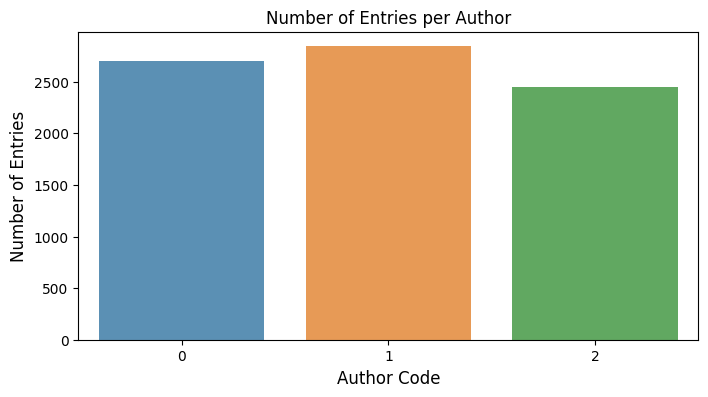

In [233]:
#Plot the author entry counts
plt.figure(figsize=(8,4))
sns.barplot(y=auth_counts['author'], x=auth_counts.index, alpha=0.8)
plt.title('Number of Entries per Author', fontsize=12)
plt.ylabel('Number of Entries', fontsize=12)
plt.xlabel('Author Code', fontsize=12)
plt.show()

Cool! We have the most entries of Fletcher, and the least of Middleton. Still, they are within 500 entries of each other, which isn't too bad.

### Total Word Counts

Let's take a moment to check out how many words we have overall in the dataset and if they follow the same distribution as the number of entries. 

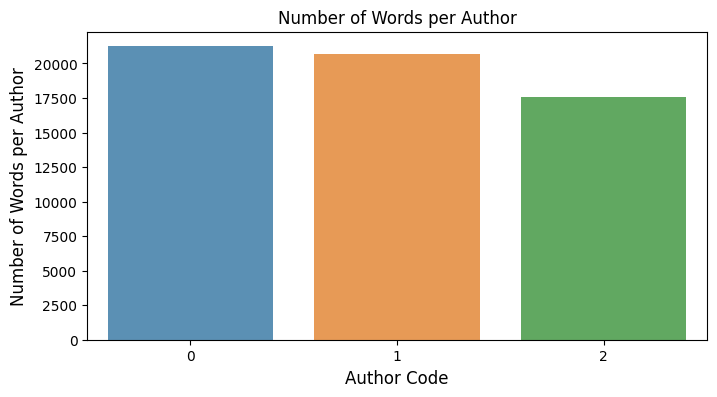

In [234]:
#Plot the author word counts
plt.figure(figsize=(8,4))
sns.barplot(y=auth_counts['num_words'], x=auth_counts.index, alpha=0.8)
plt.title('Number of Words per Author', fontsize=12)
plt.ylabel('Number of Words per Author', fontsize=12)
plt.xlabel('Author Code', fontsize=12)
plt.show()

#### Takeaway: 
While we have the most entries from Fletcher, we have the most words of Shakespeare with Middleton coming in least for both entries and word counts. Overall, while not 100% balanced, is pretty close. 

### Delving Deeper
Let's dig deeper and check out the following per entry:


*   Number of words
*   Number of unique words
*   Number of characters
*   Number of stopwords
*   Number of upper case words
*   Number of title case words
*   Number of length of words



#### Making a dataframe for analysis

Here we will make a spare dataframe just to anaylize all of the aspects of the entries in each row so we can use that later for some visuals. We won't likely use this information in our models, but I would love to see how the authors differ in some of the aspects. 

In [235]:
#Make a copy of our author codes to input the info we will need later
authors_df_analysis = authors_df[['author']].copy()

In [236]:
## Number of words in the text ##
authors_df_analysis["num_words"] = authors_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
authors_df_analysis["num_unique_words"] = authors_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
authors_df_analysis["num_chars"] = authors_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the line ##
authors_df_analysis["num_stopwords"] = authors_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of upper case words in the line ##
authors_df_analysis["num_words_upper"] = authors_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the line ##
authors_df_analysis["num_words_title"] = authors_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the line ##
authors_df_analysis["mean_word_len"] = authors_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [237]:
#Take a look at our new dataframe 
authors_df_analysis.head()

,author,num_words,num_unique_words,num_chars,num_stopwords,num_words_upper,num_words_title,mean_word_len
0,1,6,6,33,2,1,3,4.666667
1,1,8,8,40,3,0,1,4.125000
2,2,2,2,10,0,0,2,4.500000
3,1,9,8,46,3,2,3,4.222222
4,0,9,9,45,6,0,1,4.111111


#### Number of Unique Words by Author

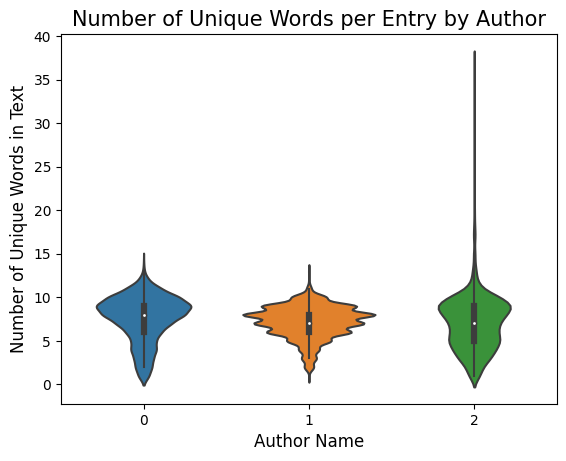

In [238]:
sns.violinplot(y = authors_df_analysis['num_unique_words'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Unique Words in Text', fontsize=12)
plt.title("Number of Unique Words per Entry by Author", fontsize=15)
plt.show()

I think it's best to take this with a grain of salt - because each play is from a different source, it's more likely that some plays are not always in the same format. In prepping the data, it may be possible to reformat the entries to be more even.

#### Number of Characters by Author

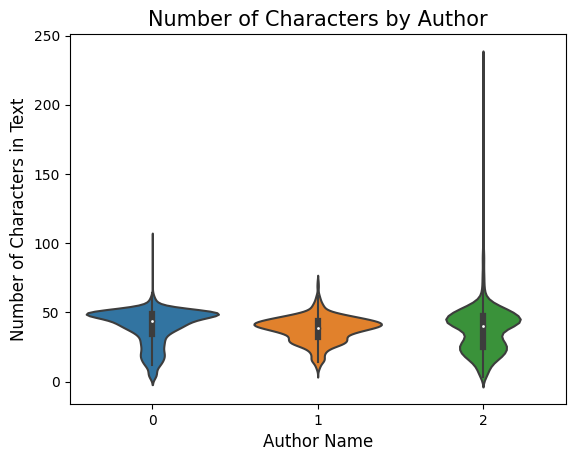

In [239]:
sns.violinplot(y = authors_df_analysis['num_chars'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Characters in Text', fontsize=12)
plt.title("Number of Characters by Author", fontsize=15)
plt.show()

#### Number of Stop Words by Author

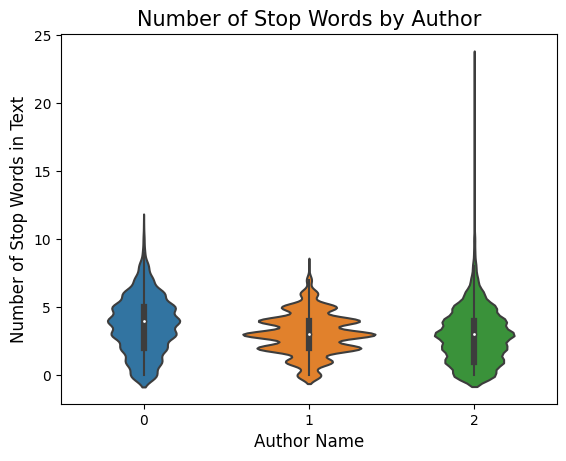

In [240]:
sns.violinplot(y = authors_df_analysis['num_stopwords'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Stop Words in Text', fontsize=12)
plt.title("Number of Stop Words by Author", fontsize=15)
plt.show()

#### Number of Uppercase Words by Author

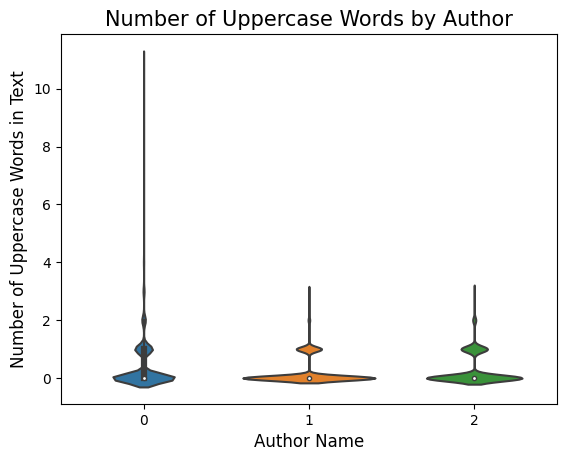

In [241]:
sns.violinplot(y = authors_df_analysis['num_words_upper'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Uppercase Words in Text', fontsize=12)
plt.title("Number of Uppercase Words by Author", fontsize=15)
plt.show()

#### Number of Titlecase Words by Author

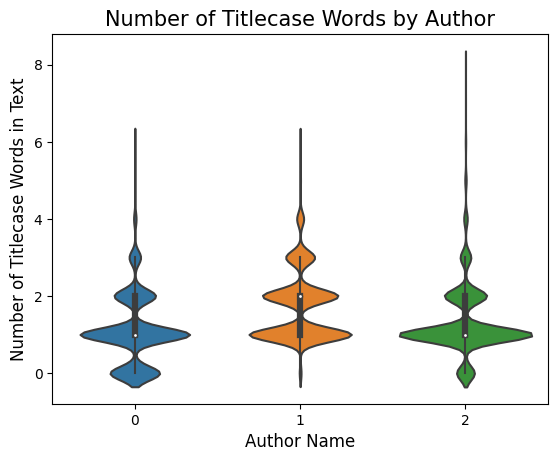

In [242]:
sns.violinplot(y = authors_df_analysis['num_words_title'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Titlecase Words in Text', fontsize=12)
plt.title("Number of Titlecase Words by Author", fontsize=15)
plt.show()

#### Number of Mean Word Length by Author

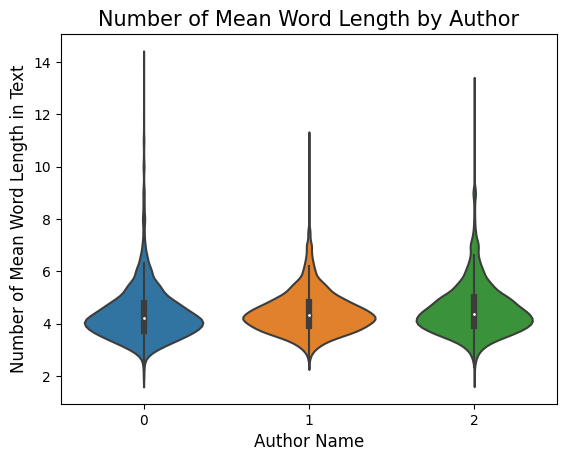

In [243]:
sns.violinplot(y = authors_df_analysis['mean_word_len'], x = authors_df_analysis['author'])
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of Mean Word Length in Text', fontsize=12)
plt.title("Number of Mean Word Length by Author", fontsize=15)
plt.show()

#### Takeaway

I love that we can see some real differences between the authors. However, I am hesitant to go ahead and include some of the aspects of these samples in the models since a lot of them are highly dependant on the formatting, which we already know isn't 100% the same throughout the three original sources. For that reason, I think we will keep this information for visual interest and focus more on the word choices themselves for modelling. 

# Data Preprocessing


---



Before we can plug our info into models, we will need to do some text cleaning to get to the root of what's being written. 
We will:

*  Remove capitalization
*  Remove line breaks
*  Remove punctuation
*  Remove stopwords
*  Remove numbers

Then, we will either stemmatize or lemmatize. Stemming uses simple heuristics and rules to strip the suffix from a word to get to it's root form (like "swimming" would be "swim"), while lemmatization finds the base of the word by its context and part of speech (like "swum" would be "swim"). For this function, we also have SpaCy available for it's own version of lemmatization based on its internal language models and rules.




### Initial Cleaning

Below we are using a function written by [Brian Roepke](https://towardsdatascience.com/text-cleaning-for-nlp-in-python-2716be301d5d), edited to suit our needs, including adding a list of custom old English stop words. We will be doing all the removals listed above in just this one function! Very cool!

In [244]:
#Import more things
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')

#Old Enlgish Stop Words
old_english_stop_words = [
    "a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it",
    "no", "not", "of", "on", "or", "such", "that", "that's", "thats" "the", "their", "then", "there", "these", "they",
    "this", "to", "was", "will", "with",
    "thou", "thee", "thy", "thine", "ye", "you", "your", "hath", "doth", "dost", "art", "wert",
    "hast", "would", "could", "should", "may", "might", "must", "shall", "tis", "til", "s"
]

# Load spacy
nlp = spacy.load('en_core_web_sm')

#Create the cleaning function
def clean_string(text, stem="None"):
    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    # Note: that this line can be augmented and used over
    # to replace any characters with nothing or a space
    text = re.sub(r'\n', '', text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation) #Makes a map of single digits so we can nab that punctuation
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words

    text = [word for word in text if not word in useless_words]
    
    # Remove Old English stop words

    new_text_filtered = [word for word in text if not word in old_english_stop_words]
   
    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in new_text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem': 
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    #create the line with all the edits done
    final_string = ' '.join(text_stemmed)

    #Return it!
    return final_string

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Great! Now that we have assessed that it works, let's continue on. 

#### Cleaning via Functions

Before cleaning with this function, we will make a copy of our original text in another column. We don't need necessarily need to do this, but I like it for the visual comparison of what we currently have and the original text. 

I should note that I already ran this a few times to try the different stem/lem options,  and decided to use the SpaCy lemmatizer. 

In [245]:
#First make a copy of all original text as a backup
authors_df['text_orig'] = authors_df['text']

#Then let the cleaning begin!
authors_df['text'] = authors_df['text'].apply(lambda x: clean_string(x, stem='Spacy'))

Let's check out the result!

In [246]:
#Show first 5 rows 
authors_df.head()

,text,author,text_orig
0,satyr softly glide goe,1,"_Satyr._ Softly gliding as I goe,"
1,sit alone sorrow sing,1,"That sits alone in sorrow, and doth sing"
2,enter tim,2,Enter Tim.
3,fain meet shepherd know,1,"I would fain meet some Shepherd, knew I where:"
4,truer wash much,0,truer than those that are so washed. How much


Squeaky clean! Now let's tokenize and take a gander at frequency distribution.

### Tokenization for Frequency Distribution Visuals
While we won't necessarily be using these tokens for modeling just yet (we will do that in the next step with uni/bigrams and beyond), we will tokenize to get a better visual represenation of the frequency distribution for all of the words of all the authors combined.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


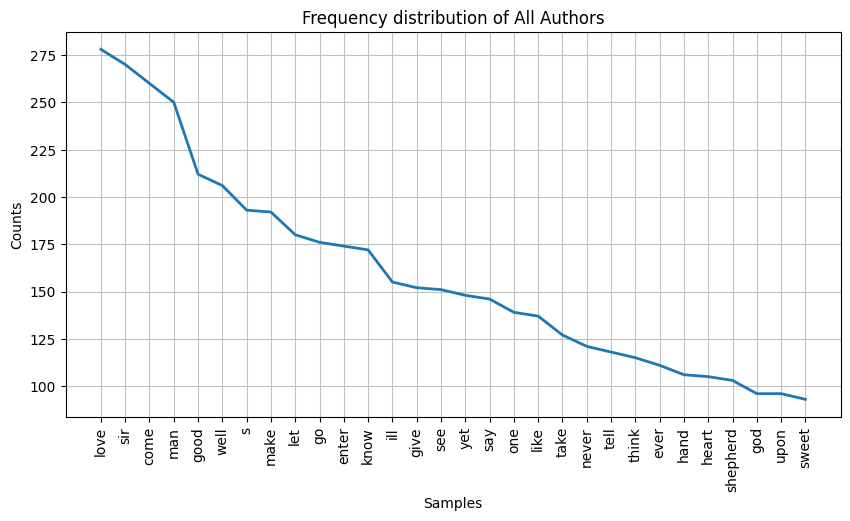

In [247]:
#Imports
from nltk import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('punkt')

###To visualize resulting word distribution

# Tokenize the text column
authors_df["text_token"] = authors_df["text"].apply(lambda x: word_tokenize(x) if x.strip() != "" else [])

# Flatten the tokens column into a single list
all_tokens = [token for tokens in authors_df["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
fdist = FreqDist(all_tokens)

plt.figure(figsize=(10, 5))
fdist.plot(30, title='Frequency distribution of All Authors');

So what we can see is a few things we will need to axe - like "enter", "one", and a few others. These are likely stage directions and don't neccessarily help us, as they are standard instructions for actors movements and pretty much guaranteed in every scene.

### Special Case Cleaning - Axing Stage Directions
Here we will axe stage directions. We could leave these in, since certain writers may change up the standard stage direction format. However, for simplicity, I'd like to focus solely on the text at hand. 

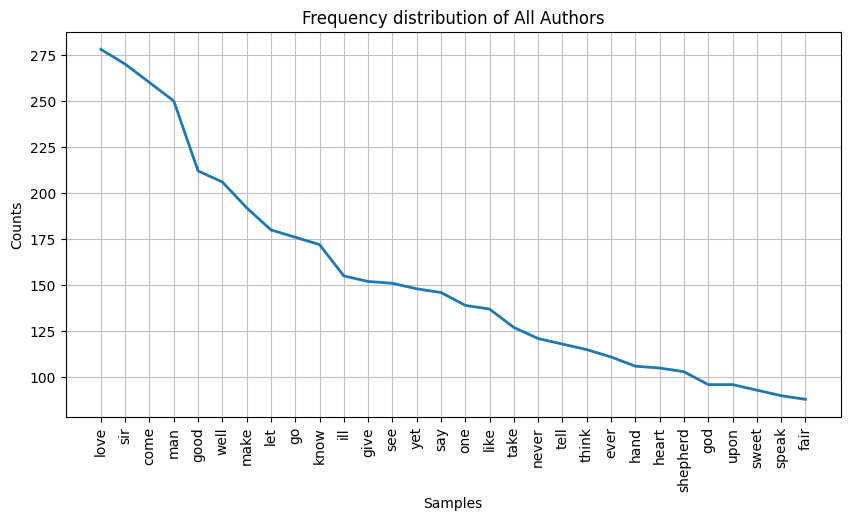

In [248]:
#define our stage directions we'd like to axe
stage_directions = [
    "enter", "exit", "exeunt", "Exeunt", "solus", "omnes", "flourish", 
    "curtain", "scene", "act", "exeunt severally", "actus", "scena", "prima", "s" 
    #This last one (s) isn't a stage direction, but an artifact from 
    #removing other words like "that" from "that's"
]

# Define a function to remove words from a string
def remove_words_from_string(word_list, input_string):
    return " ".join([word for word in input_string.split() if word.lower() not in word_list])

# Apply the function to the "text" column of the dataframe
authors_df["text"] = authors_df["text"].apply(lambda x: remove_words_from_string(stage_directions, x))


###To visualize resulting word distribution
# Tokenize the text column
authors_df["text_token"] = authors_df["text"].apply(lambda x: word_tokenize(x) if x.strip() != "" else [])

# Flatten the tokens column into a single list
all_tokens = [token for tokens in authors_df["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
fdist = FreqDist(all_tokens)

plt.figure(figsize=(10, 5))
fdist.plot(30, title='Frequency distribution of All Authors');

The result is a understandably showing a lot about love, unsurprising given that the three plays sampled are romantic comedies. I'm curious if the "ill" was "I'll" or "ill". Let's take a closer look.

In [249]:
# Count original occurrences
ill_count = authors_df["text_orig"].str.count(r"\bI'll\b", flags=re.IGNORECASE).sum()
ill_count_3 = authors_df["text_orig"].str.count(r'\bIll\b', flags=re.IGNORECASE).sum()
# Count occurrences after cleaning
ill_count_2 = authors_df["text"].str.count(r"\bI'll\b", flags=re.IGNORECASE).sum()
ill_count_4 = authors_df["text"].str.count(r'\bIll\b', flags=re.IGNORECASE).sum()

print(f"Occurrences of 'I\'ll' originally: {ill_count}")
print(f"Occurrences of 'I\'ll' now: {ill_count_2}")
print(f"Occurrences of 'ill' originally: {ill_count_3}")
print(f"Occurrences of 'ill' now: {ill_count_4}")


Occurrences of 'I'll' originally: 128
Occurrences of 'I'll' now: 0
Occurrences of 'ill' originally: 30
Occurrences of 'ill' now: 155


So what can we learn from this is it is likely that when we put the text through the function, our "I'll"'s turned to "ill" and got an incorrect count. 

Let's create a function to axe the "I'll"s before we do our cleaning.

#### Making a Function for Axing "I'll"
Now we'll make up a function and dummy df to test it.

In [250]:
#Function for axing all the I'lls
def delete_ill(text):
    final_string = ""

    # Remove stop word
    text = text.split()
    useless_word = "I'll"

    text = [word for word in text if not word in useless_word]
    #create the line with all the edits done
    final_string = ' '.join(text)

    #Return it!
    return final_string

##### Testing
Now we will make a small dummy dataframe to test it on.

In [251]:
#Make the test dataframe
illtest_df = pd.DataFrame({'text': ["I'll be well", "I'll be ill"], 'text original': ["I'll be well", "I'll be ill"]})
illtest_df.head()

,text,text original
0,I'll be well,I'll be well
1,I'll be ill,I'll be ill


Now let's test out our function on our dummy dataframe.

In [252]:
#Then let the cleaning begin!
illtest_df['text'] = illtest_df['text'].apply(lambda x: delete_ill(x))
illtest_df.head()

,text,text original
0,be well,I'll be well
1,be ill,I'll be ill


Perfect! Works as intended! Let's look at our original dataframe once more before applying the new function. 
Once that is done, we can send it through our usual cleaning function from earlier. 

In [253]:
#look at our original dataframe
authors_df.head()

,text,author,text_orig,text_token
0,satyr softly glide goe,1,"_Satyr._ Softly gliding as I goe,","[satyr, softly, glide, goe]"
1,sit alone sorrow sing,1,"That sits alone in sorrow, and doth sing","[sit, alone, sorrow, sing]"
2,tim,2,Enter Tim.,[tim]
3,fain meet shepherd know,1,"I would fain meet some Shepherd, knew I where:","[fain, meet, shepherd, know]"
4,truer wash much,0,truer than those that are so washed. How much,"[truer, wash, much]"


Now let's apply it to our new function to the data and try again. Replace the edited column with the original text and we will run the cleaning again.

In [254]:
#Overwrite the text column and let go of those tokens (Oh, how the turn tables!(Office reference))
authors_df = authors_df.drop('text_token', axis=1)
authors_df['text'] = authors_df['text_orig']

#Show first 5 rows 
authors_df.head()

,text,author,text_orig
0,"_Satyr._ Softly gliding as I goe,",1,"_Satyr._ Softly gliding as I goe,"
1,"That sits alone in sorrow, and doth sing",1,"That sits alone in sorrow, and doth sing"
2,Enter Tim.,2,Enter Tim.
3,"I would fain meet some Shepherd, knew I where:",1,"I would fain meet some Shepherd, knew I where:"
4,truer than those that are so washed. How much,0,truer than those that are so washed. How much


Now let's axe the "I'll"s and check it out.

In [255]:
#Let the "I'll" axing begin!
authors_df['text'] = authors_df['text'].apply(lambda x: delete_ill(x))
#Show first 5 rows
authors_df.head()

,text,author,text_orig
0,"_Satyr._ Softly gliding as goe,",1,"_Satyr._ Softly gliding as I goe,"
1,"That sits alone in sorrow, and doth sing",1,"That sits alone in sorrow, and doth sing"
2,Enter Tim.,2,Enter Tim.
3,"would fain meet some Shepherd, knew where:",1,"I would fain meet some Shepherd, knew I where:"
4,truer than those that are so washed. How much,0,truer than those that are so washed. How much


And now we do our usual cleaning...

In [256]:
#normal cleaning
authors_df['text'] = authors_df['text'].apply(lambda x: clean_string(x, stem='Spacy'))
#Show first 5 rows 
authors_df.head()

,text,author,text_orig
0,satyr softly glide goe,1,"_Satyr._ Softly gliding as I goe,"
1,sit alone sorrow sing,1,"That sits alone in sorrow, and doth sing"
2,enter tim,2,Enter Tim.
3,fain meet shepherd know,1,"I would fain meet some Shepherd, knew I where:"
4,truer wash much,0,truer than those that are so washed. How much


And finally, we tokenize to see our frequency distribution.

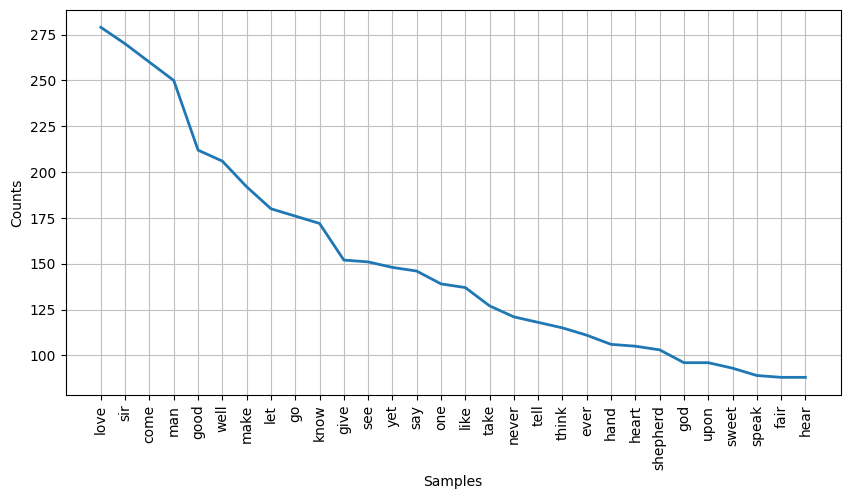

In [257]:
###To visualize resulting word distribution


# Apply the function to the "text" column of the dataframe
authors_df["text"] = authors_df["text"].apply(lambda x: remove_words_from_string(stage_directions, x))


# Tokenize the text column
authors_df["text_token"] = authors_df["text"].apply(lambda x: word_tokenize(x) if x.strip() != "" else [])

# Flatten the tokens column into a single list
all_tokens = [token for tokens in authors_df["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
fdist = FreqDist(all_tokens)

plt.figure(figsize=(10, 5))
fdist.plot(30);

Very cool! Now we have a better (and more accurate) account of our frequency distribution.

### Distribution of Words Per Author
Now we will do the same as before but instead of the frequency among the entire body of work of the three authors together, we will analyze the frequency of each individual author.

#### Shakespeare

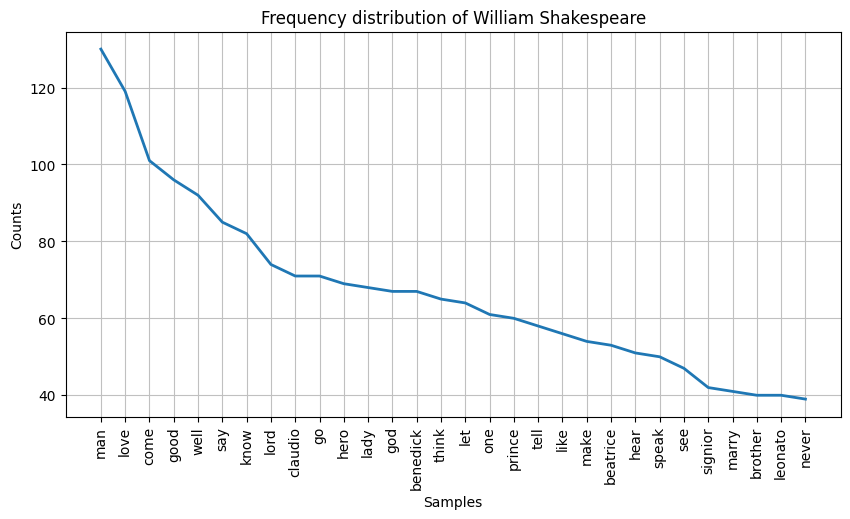

<Axes: title={'center': 'Frequency distribution of William Shakespeare'}, xlabel='Samples', ylabel='Counts'>

In [258]:
#Filter df for just Shakespeare lines
shakes_frequency = authors_df[authors_df['author'] == 0]

##To visualize resulting word distribution
# Flatten the tokens column into a single list
shakes_all_tokens = [token for tokens in shakes_frequency["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
shakes_fdist = FreqDist(shakes_all_tokens)

plt.figure(figsize=(10, 5))
shakes_fdist.plot(30, title='Frequency distribution of William Shakespeare')


#### Middleton
Now we will do the same for Middleton!

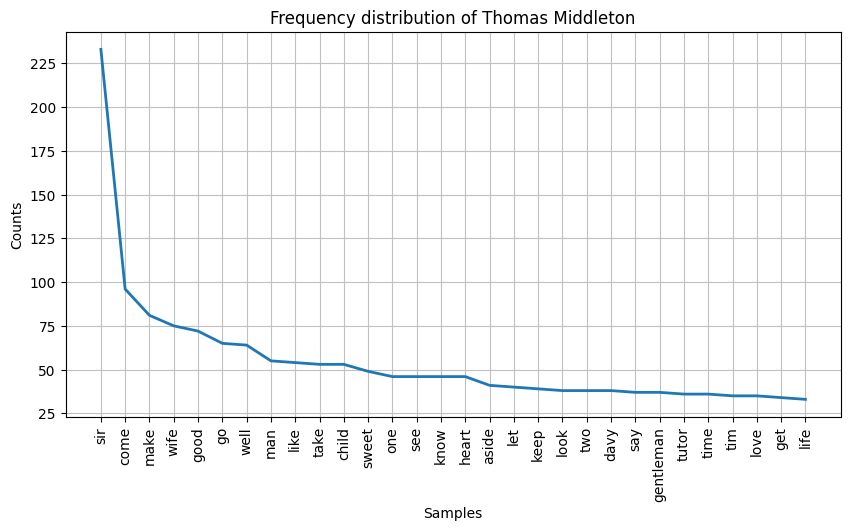

<Axes: title={'center': 'Frequency distribution of Thomas Middleton'}, xlabel='Samples', ylabel='Counts'>

In [259]:
#Filter df for just Shakespeare lines
mids_frequency = authors_df[authors_df['author'] == 2]

##To visualize resulting word distribution
# Flatten the tokens column into a single list
mids_all_tokens = [token for tokens in mids_frequency["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
mids_fdist = FreqDist(mids_all_tokens)

plt.figure(figsize=(10, 5))
mids_fdist.plot(30, title='Frequency distribution of Thomas Middleton')


#### Fletcher
Last, but not least, let's do the same for Fletcher!

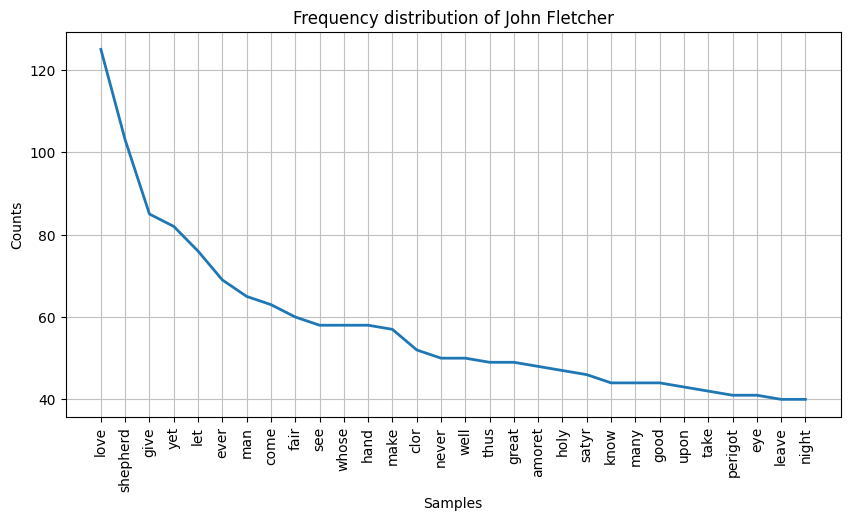

<Axes: title={'center': 'Frequency distribution of John Fletcher'}, xlabel='Samples', ylabel='Counts'>

In [260]:
#Filter df for just Shakespeare lines
fletcher_frequency = authors_df[authors_df['author'] == 1]

##To visualize resulting word distribution
# Flatten the tokens column into a single list
fletcher_all_tokens = [token for tokens in fletcher_frequency["text_token"] for token in tokens]

# Calculate the frequency distribution of the tokens
fletcher_fdist = FreqDist(fletcher_all_tokens)

plt.figure(figsize=(10, 5))
fletcher_fdist.plot(30, title='Frequency distribution of John Fletcher')


#### Takeaway

Considering that this play talks a lot about a shepherd/ess, it is unsuprising that it sould be used so prominently. I do find it interesting how both Fletcher and Middleton used the call to action word of "come" often, while Shakespeare often used the call to action word "go". Unsurprisingly, all authors talk about love and men, since so often these plays are told a bit more through a mans perspective, or feature a lot of conversations between men persuing the love of a woman.

# Feature Creation


---



Here we will analyse the text further and pull out or compute features that will help us in the future when modeling. We will be looking at:

*   Punctuation and Line Length
*   Uni and Bigrams 
*   Word2Vec Embeddings to use in an SVC later 



### Punctuation/Line length
Here we will examine the percentage of punctuation used in each line, as well as log the length of the characters in each line.

In [261]:
# Function to calculate length of line excluding space
authors_df['text_len'] = authors_df['text_orig'].apply(lambda x: len(x) - x.count(" "))

#Define the function
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

#Running it!
authors_df['punct%'] = authors_df['text_orig'].apply(lambda x: count_punct(x))

#Checking out the result
authors_df.head()

,text,author,text_orig,text_token,text_len,punct%
0,satyr softly glide goe,1,"_Satyr._ Softly gliding as I goe,","[satyr, softly, glide, goe]",28,14.3
1,sit alone sorrow sing,1,"That sits alone in sorrow, and doth sing","[sit, alone, sorrow, sing]",33,3.0
2,tim,2,Enter Tim.,[tim],9,11.1
3,fain meet shepherd know,1,"I would fain meet some Shepherd, knew I where:","[fain, meet, shepherd, know]",38,5.3
4,truer wash much,0,truer than those that are so washed. How much,"[truer, wash, much]",37,2.7


In [262]:
#For curiosity sake, let's see the longest text length 
authors_df['text_len'].max()

187

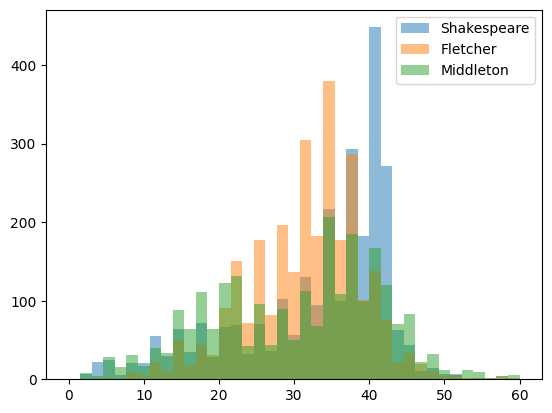

In [263]:
#Visualize the relationships between the three authors via the length of each line
bins = np.linspace(0, 60, 40)
plt.hist(authors_df[authors_df['author']==0]['text_len'], bins, alpha=0.5, label='Shakespeare')
plt.hist(authors_df[authors_df['author']==1]['text_len'], bins, alpha=0.5, label='Fletcher')
plt.hist(authors_df[authors_df['author']==2]['text_len'], bins, alpha=0.5, label='Middleton')
plt.legend(loc='upper right')
plt.show()

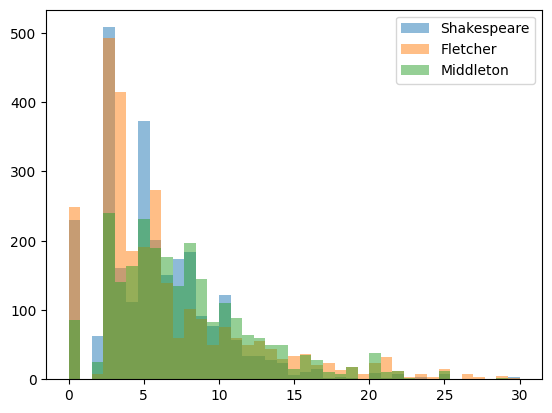

In [264]:
#Visualize the relationships between the three authors via their use of punctuation
bins = np.linspace(0, 30, 40)
plt.hist(authors_df[authors_df['author']==0]['punct%'], bins, alpha=0.5, label='Shakespeare')
plt.hist(authors_df[authors_df['author']==1]['punct%'], bins, alpha=0.5, label='Fletcher')
plt.hist(authors_df[authors_df['author']==2]['punct%'], bins, alpha=0.5, label='Middleton')
plt.legend(loc='upper right')
plt.show()

#### Takeaway:
There are some significant outliers here, but overall we can see that there are differences between the three authors in both puctuation and line length. 

However, we should take this with a grain of salt considering that the three datasets, while all having all the lines from their respective plays, were from different sources and were not uniformally distributed in their datasets. For this reason, I don't think we will end up using this data.

### Bag of Words 

Bag of Words is a technique used in Natural Language Processing to represent text as a collection of words (either with unigrams or bigrams), ignoring grammar and word order (ignoring bigrams, of course). It counts the frequency of each word (or bigram) in a document and creating a vector that represents the document based on the word frequencies.

#### Unigrams
First we will make a dataframe of unigrams (or essentially just the singular words used).

In [265]:
#make base df
authors_df_cleaned = authors_df[['author', 'text']]
#check it out
authors_df_cleaned

,author,text
0,1,satyr softly glide goe
1,1,sit alone sorrow sing
2,2,tim
3,1,fain meet shepherd know
4,0,truer wash much
...,...,...
7994,1,world goodness fear
7995,0,master constable go way examine
7996,0,beseech worship correct
7997,1,alexis strong alexis high free


In [266]:
#Vectorize the words to put into a new dataframe 
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(authors_df_cleaned['text'])

#Preview results
print(X_counts.shape)
print(count_vect.get_feature_names_out())
X_counts

(7999, 4844)
['abbington' 'abe' 'abhor' ... 'zeal' 'zealous' 'zephyrus']


<7999x4844 sparse matrix of type '<class 'numpy.int64'>'
	with 28288 stored elements in Compressed Sparse Row format>

In [267]:
#Hook up into the new dataframe
X_counts_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())
#Check it out
X_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Columns: 4844 entries, abbington to zephyrus
dtypes: int64(4844)
memory usage: 295.6 MB


#### Bigrams
Next we will make a dataframe of bigrams (or essentially 2-word combinations in how they appear in the text ex. "I love reading" would result in "I love" and "love reading").

In this case we are using bigrams

In [268]:
ngram_vect = CountVectorizer(ngram_range=(2,2))
biX_counts = ngram_vect.fit_transform(authors_df_cleaned['text'])
print(biX_counts.shape)
print(ngram_vect.get_feature_names_out())

(7999, 18644)
['abe ease' 'abe sir' 'abhor sin' ... 'zealous faith' 'zealous meditation'
 'zephyrus play']


In [269]:
biX_counts_df = pd.DataFrame(biX_counts.toarray(), columns=ngram_vect.get_feature_names_out())
biX_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Columns: 18644 entries, abe ease to zephyrus play
dtypes: int64(18644)
memory usage: 1.1 GB


#### Combining Unigrams and Bigrams

In [270]:
#Combine the unigrams and bigrams dfs
gram_counts = pd.merge(X_counts_df, biX_counts_df, left_index=True, right_index=True)
#Preview
gram_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Columns: 23488 entries, abbington to zephyrus play
dtypes: int64(23488)
memory usage: 1.4 GB


In [271]:
#As it turns out, there is author somewhere within all the sampled text. We could rename our author column, or axe the non-calssifier column
gram_counts = gram_counts.drop(columns=['author'])

In [272]:
#add in the classifier 
gram_counts = gram_counts.join(authors_df['author'])
#See the result
gram_counts.head()

,abbington,abe,abhor,abide,ability,able,abominable,abroad,absence,absent,...,youth swell,youth year,youthconsuming miserie,youthful coronal,zeal bring,zeal heart,zealous faith,zealous meditation,zephyrus play,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Word list pickle
Here we will make a copy of the unigrams and bigrams for later in the deployment stage.

In [273]:
import pickle
#Make a list of words and word combos in the dataframe
word_list = list(gram_counts)

#Pickle it! 
with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/nb_word_list.pkl', 'wb') as f:
    pickle.dump(word_list, f)

### Word2Vec Embeddings
Word2vec is a two-layer neural net that processes text by “vectorizing” words, also known as neural word embeddings. These vectors describe how close or far words are against other words that neighbor them in the input corpus with similar things and ideas are shown to be “close”. Their relative meanings have been translated to measurable distances.

In [274]:
#Tokenize our words
tokenized = authors_df['text'].apply(lambda x: x.split()) # tokenizing 
tokenized

0                 [satyr, softly, glide, goe]
1                  [sit, alone, sorrow, sing]
2                                       [tim]
3                [fain, meet, shepherd, know]
4                         [truer, wash, much]
                        ...                  
7994                  [world, goodness, fear]
7995    [master, constable, go, way, examine]
7996              [beseech, worship, correct]
7997     [alexis, strong, alexis, high, free]
7998      [two, little, heaven, upon, ground]
Name: text, Length: 7999, dtype: object

Here we will make a model to calculate all of the embeddings. We will save it for later to use in our SVM model later.

In [275]:
%%time
import gensim

model_w2v = gensim.models.Word2Vec(
            tokenized,
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized, total_examples=len(tokenized), epochs=20)

# Save the model to Google Drive for using in our SVM model later!
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/word2vec_model.pkl', 'wb') as f:
    pickle.dump(model_w2v, f)

CPU times: user 4.78 s, sys: 85.1 ms, total: 4.87 s
Wall time: 2.19 s


For fun, let's check it out! Let's first see how many tokens we have. 

In [276]:
len(tokenized)

7999

Cool! Now let's see it in action. Let's put in a word and see the closest/most similar words to it. Since these are all romantic comedies, let's do "love"!

In [277]:
model_w2v.wv.most_similar(positive="love")

[('swear', 0.8310918807983398),
 ('friend', 0.8063139915466309),
 ('didst', 0.802322506904602),
 ('suffer', 0.794376015663147),
 ('simple', 0.7716629505157471),
 ('truly', 0.771147608757019),
 ('torment', 0.7697729468345642),
 ('pleasant', 0.769338071346283),
 ('none', 0.7692832946777344),
 ('constant', 0.7673937678337097)]

#### Making the vectors

Now let's make a function to make the vector feature set into a dataframe that we can use later.

In [278]:
#function to make vectors 
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

Using the function to prepare word2vec feature set…

In [279]:
wordvec_arrays = np.zeros((len(tokenized), 100)) 
for i in range(len(tokenized)):
    wordvec_arrays[i,:] = word_vector(tokenized[i], 100)
#save feature set as new df
wordvec_df = pd.DataFrame(wordvec_arrays)
#check shape
wordvec_df.shape

(7999, 100)

In [280]:
#check out the new df
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.053936,-0.387643,0.083334,-0.074909,-0.246964,0.089164,0.110838,-0.269363,0.251976,0.110683,...,-0.143733,-0.031845,0.244358,-0.003061,0.163907,0.183583,-0.196896,-0.200961,0.249906,0.066511
1,0.105015,-0.510586,0.139877,-0.140378,-0.339244,0.119803,0.047788,-0.317147,0.255479,0.054595,...,0.066134,-0.101344,0.262490,0.017619,0.066038,0.173045,-0.157014,-0.138242,0.159389,0.043686
2,0.179920,0.059973,-0.141109,0.029763,-0.366781,0.102183,0.102481,-0.170022,0.199386,-0.147641,...,0.410319,-0.324909,0.389054,0.001634,0.072108,-0.348758,-0.150062,-0.303786,0.412396,0.142076
3,0.219977,-0.285527,0.029796,-0.046425,-0.025208,0.125067,0.122114,-0.451060,0.223145,-0.115336,...,-0.033533,-0.029604,0.256230,-0.057486,0.205495,0.110421,-0.286650,-0.171702,0.201162,0.007006
4,0.110330,-0.174131,0.000376,-0.096279,-0.250106,0.189850,0.119124,-0.211773,0.185197,0.115561,...,0.047859,-0.184558,0.293959,0.038141,0.073890,-0.009253,-0.138444,-0.118393,0.108003,0.144997


Lovely! We will use this later. Let's move on to visualizations!

## More Visuals


---


Now that we have cleaned and prepped the data, let's take a moment to see how some more of the words can be visualized before we go into modeling. 

We will check out TSNE (or t-SNE, t-Distributed Stochastic Neighbor Embedding), which is a dimensionality reduction technique used to shows the relationships between between local data points while emphasizing the separation of dissimilar points. Then we will look into word clouds to get a fun visual on word frequencies for each author. 

#### TSNE Plot for Visual
A pretty wild one once assembled, a TSNE plot will show us how words relate to each other in the texts, with words being plotted closer to other words it is commonly used with.

In [281]:
from sklearn.manifold import TSNE
#Function to plot a tsne
def plot_tsne(model):
    """Create a two-dimensional plot of word embeddings using t-SNE.
    """

    # Get the vocabulary and word vectors from the model
    vocab = list(model.wv.key_to_index)
    word_vectors = np.array([model.wv[word] for word in vocab])

    # Use t-SNE to reduce the dimensionality of the word vectors
    tsne = TSNE(n_components=2, random_state=0)
    word_vectors_tsne = tsne.fit_transform(word_vectors)

    # Plot the word embeddings
    plt.figure(figsize=(20, 20))
    for i, word in enumerate(vocab):
        x, y = word_vectors_tsne[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.show()

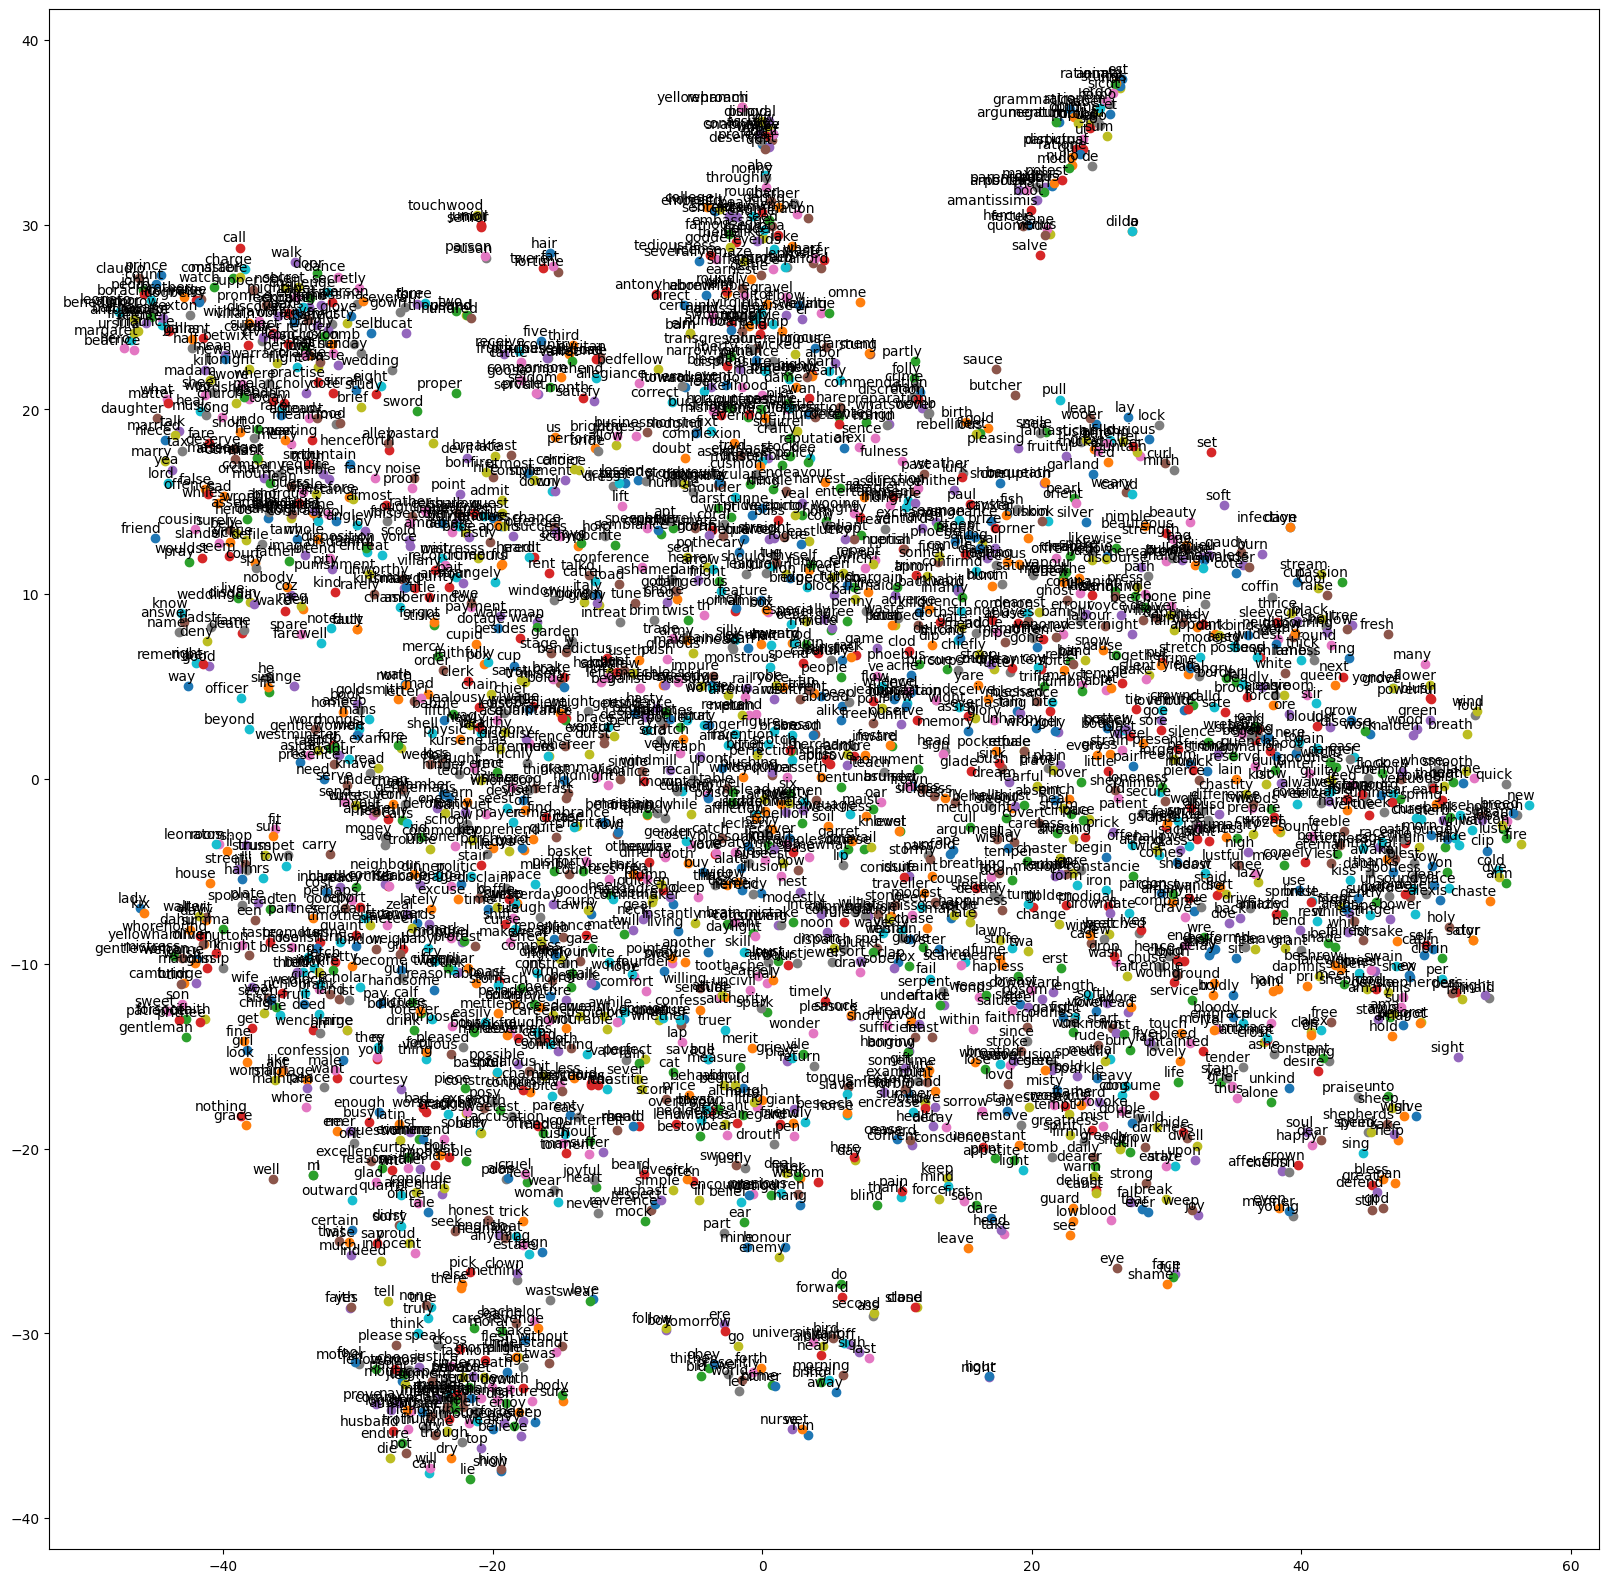

In [282]:
#plot it
plot_tsne(model_w2v)

Though it is hard to see with so many words, it is still very cool to examine. We could limit the amount of words we plot, but for now, let's leave it as is and move on. 

### Word Cloud Visuals
Perhaps one of my favorites, let's get some word clouds to get a better visual on how their word choices compare. In a word cloud, the size of each word corresponds to its frequency or importance in the given text. 

#### Shakespeare
For William, we are going to make his cloud look like himself because he's just so iconic, why not?

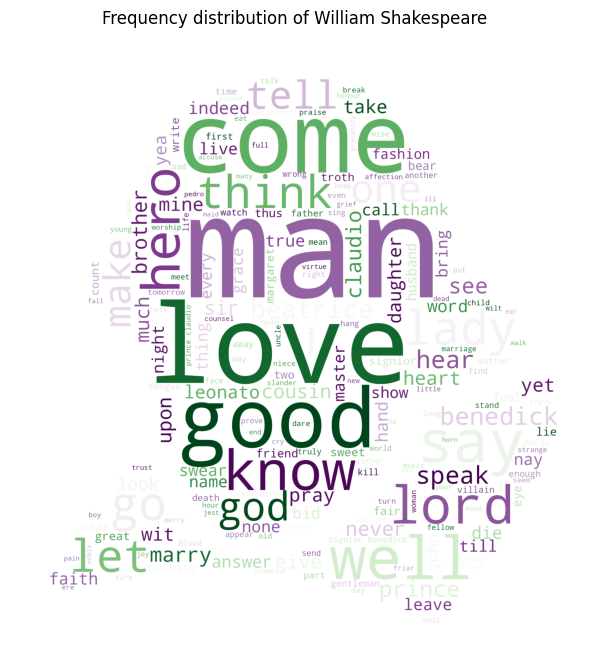

In [283]:
#just get Williams words
shakes_words = ' '.join([text for text in authors_df['text'][authors_df['author'] == 0]])
#imports
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
# Function to create wordcloud
def generate_better_wordcloud(data, title, mask=None, colormap=None):
    cloud = WordCloud(colormap=colormap,
                      mask=mask,
                      background_color='white',
                      random_state=21).generate(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create an array from the image 
shakes = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/images/shakes.jpg'))
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(shakes_words, 'Frequency distribution of William Shakespeare', mask=shakes, colormap="PRGn")


#### Thomas Middleton
For Middletons play, we will make his cloud look like a woman in honor of the maid. 

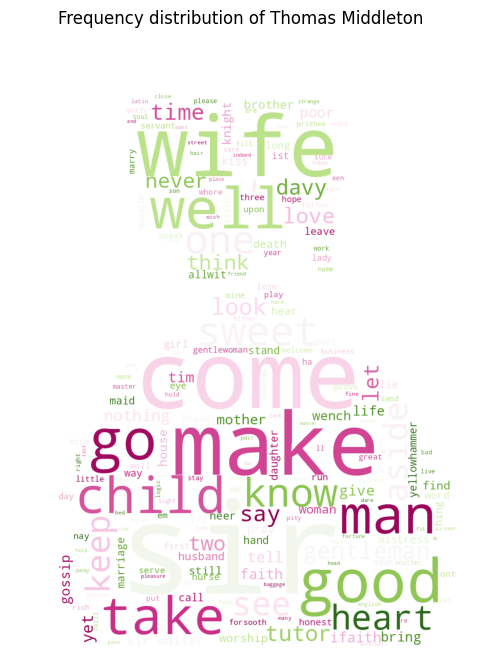

In [284]:
#get Thomas Middletons words
mids_words = ' '.join([text for text in authors_df['text'][authors_df['author'] == 2]])
# Create an array from the image 
court = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/images/court.jpg'))
  
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(mids_words, 'Frequency distribution of Thomas Middleton', mask=court, colormap="PiYG")


#### Fletcher
For fun, we made this word cloud look like a sheep head. Awesome!

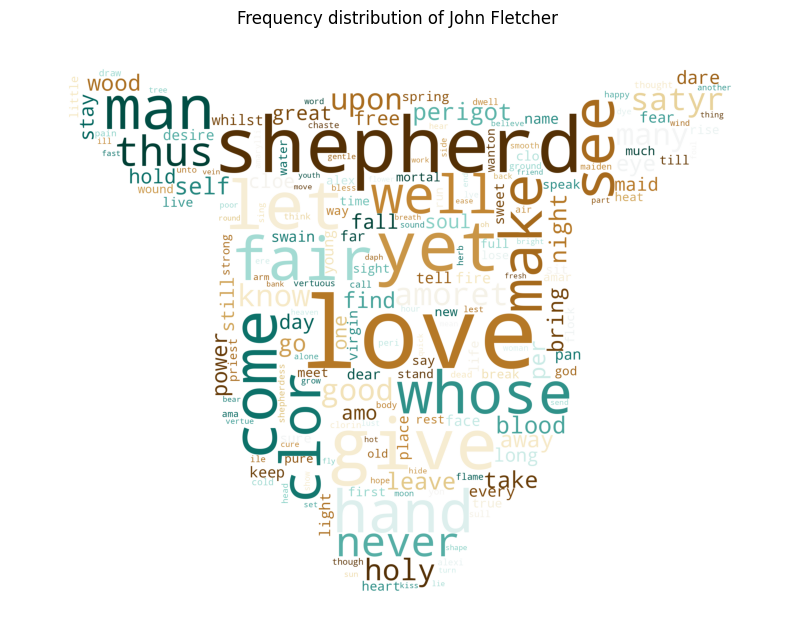

In [285]:
#get Fletchers words
fletcher_words = ' '.join([text for text in authors_df['text'][authors_df['author'] == 1]])

# Create an array from the image 
sheep = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/images/sheep.jpg'))
  
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(fletcher_words, 'Frequency distribution of John Fletcher', mask=sheep, colormap="BrBG")


# Train and Test the Models


---


*   Random Forest Classifier using CountVectorizer to vectorize and analyze
*   Naive Bayes Model using the vectors from our Bag of Words uni- and bigrams
*   Support Vector Classifier (SVC) using the vectors from our word2vec model as embeddings!
*  For fun, we will even try a Logistic Regression on authors_df_analysis

For each model, we will be using GridSearchCV to find the best hyperparameters and improve on our initial model. It searches through a specified hyperparameter grid to find the best combination of hyperparameter, using cross-validation to assess performance.


##Random Forest
RandomForestClassifier is a type of ensemble learning method in which multiple decision tree models are trained on different random subsets of the training data. During prediction, each decision tree model makes a prediction, and the final prediction is determined by majority voting. This technique reduces overfitting and improves the overall performance of the model.

### Initial Model
Let's get our base model and see how it fairs.

In [286]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#label our X and y
X = authors_df['text']
y = authors_df['author']

# Split the data into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, stratify=y)

# Create a CountVectorizer object to convert text into numerical features
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(X_train_rf)

# Transform the training and test data using the vectorizer
X_train_vec_rf = vectorizer.transform(X_train_rf)
X_test_vec_rf = vectorizer.transform(X_test_rf)

# Create a Random Forest model and train it on the training data
rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt")
rf.fit(X_train_vec_rf, y_train_rf)

# Evaluate the model on the test data
y_pred_rf = rf.predict(X_test_vec_rf)
acc_rf = accuracy_score(y_test_rf, y_pred_rf)
report_rf = classification_report(y_test_rf, y_pred_rf)
print(f"Accuracy: {acc_rf:.4f}")
print(f"Classification report:\n{report_rf}")

Accuracy: 0.5331
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.30      0.44       541
           1       0.44      0.98      0.61       568
           2       0.87      0.27      0.41       491

    accuracy                           0.53      1600
   macro avg       0.72      0.52      0.49      1600
weighted avg       0.71      0.53      0.49      1600



### GridSearchCV for Best Case Hyperparameters

I'd like to try a girdsearch to find the best parameters for this RF model. However, it will take ages, so do yourself a favor - run it, then go make some tea, take a nap, fix something you've been meaning to fix but can't find the time for, put your clothes away, or literally anything else that will occupy you for at least 1, but maybe 2, episodes of The Great British Baking Show.

Just make sure you run it first!

(You could also just skip ahead to the result that I copied below)

In [287]:
from sklearn.model_selection import GridSearchCV

## Define the parameters to search
#param_grid = {
#    'n_estimators': [100, 200],
#    'max_depth': [10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2', None]
#}

# Use GridSearchCV to search for the best hyperparameters
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_train_vec, y_train)

# Print the best hyperparameters and their corresponding score
#print(f"Best parameters: {grid_search.best_params_}")
#print(f"Best score: {grid_search.best_score_}")

Best parameters: `{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}`

Best score: 0.621034866106333

### Final RandomForestClassifier Model
Now let's use those hyperparameters to improve our model!

In [288]:
# Create a Random Forest model and train it on the training data
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=200)
rf.fit(X_train_vec_rf, y_train_rf)

# Evaluate the model on the test data
y_pred_rf = rf.predict(X_test_vec_rf)
acc_rf = accuracy_score(y_test_rf, y_pred_rf)
report_rf = classification_report(y_test_rf, y_pred_rf)
print(f"Accuracy: {acc_rf:.4f}")
print(f"Classification report:\n{report_rf}")

Accuracy: 0.6412
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.59      0.66       541
           1       0.54      0.96      0.69       568
           2       0.92      0.34      0.49       491

    accuracy                           0.64      1600
   macro avg       0.74      0.63      0.62      1600
weighted avg       0.73      0.64      0.62      1600



Overall, 62% accuracy isn't bad, though I personally would want more accuracy.

##  Naive Bayes Model
Multinomial Naive Bayes (MNB) is a probabilistic algorithm used for classification problems with discrete features, which makes it great for text classification. It models the conditional probability distribution of the data for each class, assuming that the features are independent and follow a multinomial distribution.

### Initial Model

Let's get our base model and see how it fairs.

In [289]:
# create feature matrix X and target variable y
X = gram_counts.drop('author', axis=1) # drop the target column
y = gram_counts['author']

# split data into training and test sets
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# train the model
nb = MultinomialNB()
nb.fit(X_train_nb, y_train_nb)

#test the model
y_pred_nb = nb.predict(X_test_nb)
accuracy_nb = nb.score(X_test_nb, y_test_nb)
print("Accuracy: {:.2f}%".format(accuracy_nb * 100))
report_nb = classification_report(y_test_nb, y_pred_nb)
print(f"Classification report:\n{report_nb}")

Accuracy: 73.69%
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       541
           1       0.74      0.81      0.77       568
           2       0.76      0.71      0.73       491

    accuracy                           0.74      1600
   macro avg       0.74      0.73      0.74      1600
weighted avg       0.74      0.74      0.74      1600



This accuracy is considerably better that before! Let's see if we can advance it more.

#### For later - Side Quest
So let's take a moment to take a side quest. While we are here, we will make a blank dataframe that has the setup of the X_test_nb. We will use this later when we hook our model up to Gradio to make a functional app. We will also pickle the model itself, unless we run into a better model later.

In [290]:
# create a new single-row dataframe with 0 entries and column names from the sample dataframe
new_empty_df = pd.DataFrame(0, index=[0], columns=X_test_nb.columns)

# pickle the new dataframe
with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/new_empty_df.pkl', 'wb') as f:
    pickle.dump(new_empty_df, f)

In [291]:
#Pickle the model itself... for later! 
with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/nb_model.pkl', 'wb') as f:
    pickle.dump(nb, f)

### Adding Additional Features
Here we will try out the model with the text_len and punctuation percentage to see if it improves our model. 

In [292]:
#add in our other features of text length and punctuation
gram_counts = gram_counts.join(authors_df[['text_len', 'punct%']])

In [293]:
# Rerun the model with this additional data

# create feature matrix X and target variable y
X_more = gram_counts.drop('author', axis=1) # drop the target column
y_more = gram_counts['author']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_more, y_more, test_size=0.2, stratify=y_more, random_state=42)

# train the model
nb_more = MultinomialNB()
nb_more.fit(X_train, y_train)

# test the model
accuracy = nb_more.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 73.56%


Oof, it was a nice thought, but let's leave those out in the future when we aim to improve our model.

In [294]:
#Taking it *back out* 
gram_counts = gram_counts.drop(['text_len', 'punct%'], axis=1)

### GridsearchCV for Best Case Hyperparameters
Now given that info, let's see if we can find a best-case scenario to work with. 

In [295]:
# define the parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0],
              'fit_prior': [True, False]}

# perform the grid search
grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5)
grid_search_nb.fit(X_train_nb, y_train_nb)

# print the best parameters and best score
print("Best parameters: ", grid_search_nb.best_params_)
print("Best score: ", grid_search_nb.best_score_)

Best parameters:  {'alpha': 0.5, 'fit_prior': False}
Best score:  0.7377741399530884


How is this best score somehow lower than our original baseline model? Curious, very curious. 

Well, in that case, let's just stick to our initial SB model. 

## Support Vector Classifier (SVC) Model
A Support Vector Classifier (SVC) is a ML algorithm that aims to find the optimal hyperplane that separates different classes in the data by maximizing the margin between them.

###Initial Model
Let's run a basic model to start out. This will go a little differently than the other models because we will need to call our earlier word2vec model to process, and we will need to eventually turn our tests and trains into lists to use with the SVC. It's a bit involved, but it's worth it, so let's tuck in!

In [77]:
# Load the model from Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/word2vec_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Function to generate embeddings for each phrase in the dataframe
def get_embedding(phrase):
    words = [word for word in phrase.lower().split() if word in model.wv.key_to_index]
    if len(words) > 0:
        return sum([model.wv[word] for word in words]) / len(words)
    else:
        return None

authors_df['embeddings'] = authors_df['text'].apply(get_embedding)
authors_df = authors_df.dropna()

In [78]:
# Define your features and target variable
X = authors_df['embeddings']
y = authors_df['author']

# Split your data into a training set and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the temporary set into a validation set and a test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shape of each set
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (6272,) (6272,)
Validation set: (784,) (784,)
Test set: (785,) (785,)


In [79]:
from sklearn.svm import SVC
#convert these into lists
X_train_clf2 = list(X_train) 
y_train_clf2 = list(y_train) 
X_test_clf2 = list(X_test) 
y_test_clf2 = list(y_test) 
# Train the SVM classifier on the embeddings
clf = SVC(kernel='linear')
clf.fit(X_train_clf2, y_train_clf2)

# Evaluate the performance of the SVM classifier on the test set
y_pred_clf2 = clf.predict(X_test_clf2)
accuracy_clf2 = accuracy_score(y_test_clf2, y_pred_clf2)

#Show accuracy
print("Accuracy: {:.2f}%".format(accuracy_clf2 * 100))
#Create a classification report
print(classification_report(y_test_clf2, y_pred_clf2))

Accuracy: 70.19%
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       263
           1       0.72      0.81      0.76       283
           2       0.74      0.61      0.67       239

    accuracy                           0.70       785
   macro avg       0.70      0.70      0.70       785
weighted avg       0.70      0.70      0.70       785



That's not bad, let's see if we can improve the accuracy score a bit with a grid search.

### GridsearchCV for Best Hyperparameters

In [80]:
# define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10],}

# initialize the SVC model
svc = SVC()

# initialize the grid search
grid_search = GridSearchCV(svc, param_grid, cv=5)

# fit the grid search to your data
grid_search.fit(X_train_clf2, y_train_clf2)

# print the best parameters found by the grid search
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


###Final Model
Let's take those params and see where it gets us.

In [81]:
# Train the SVM classifier on the embeddings
clf2 = SVC(C=10, gamma= 0.1, kernel= 'rbf')
clf2.fit(X_train_clf2, y_train_clf2)

# Evaluate the performance of the SVM classifier on the test set
y_pred_clf2 = clf2.predict(X_test_clf2)
accuracy_clf2 = accuracy_score(y_test_clf2, y_pred_clf2)
print("Accuracy: {:.2f}%".format(accuracy_clf2 * 100))

Accuracy: 70.83%


In [82]:
#Create a classification report
report_clf2 = classification_report(y_test_clf2, y_pred_clf2)
print(f"Classification report:\n{report_clf2}")

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       263
           1       0.72      0.82      0.76       283
           2       0.74      0.62      0.68       239

    accuracy                           0.71       785
   macro avg       0.71      0.70      0.70       785
weighted avg       0.71      0.71      0.71       785



All that work with only a marginal increase. It's a bummer, but I'm glad we tried it.

### For Fun - Logistic Regresion of authors_df_analysis
I don't expect a lot to come from this, since there is a lot less info here than with our Uni/Bigrams or Word2Vec Embeddings, but let's try it!

In [83]:
from sklearn.linear_model import LogisticRegression

# Assign X and y
X = authors_df_analysis.drop('author', axis=1)
y = authors_df_analysis['author']

# Split dataset
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
clf_lg = LogisticRegression(max_iter=1000)
clf_lg.fit(X_train_lg, y_train_lg)

# Predict on test set
y_pred_lg = clf_lg.predict(X_test_lg)
accuracy_lg = accuracy_score(y_test_lg, y_pred_lg)
print("Accuracy: {:.2f}%".format(accuracy_lg * 100))

Accuracy: 50.12%


Interestingly enough, though problably not surprisingly, these items weren't different enough to work as well as the other methods to classify authors. We'll just leave this right here. 

# Model Evaluation
We have three models that we analyzed the data with and ran different optimizations for:


1.   Random Forest Classifier
2.   Multinomial Naive Bayes (MNB)
3.   Support Vector Classifier (SVC) Model (with Gridsearch)



Let's take a quick moment to review what values we are looking at in our classification report.
* **Precision** is the ratio of correctly predicted positive instances to the total predicted positive instances. 
* **Recall** is the ratio of correctly predicted positive instances to the total actual positive instances. 
* **F1-score** is the harmonic mean of precision and recall.
* **Accuracy** is the ratio of correctly predicted instances to the total instances. Essentially, the overall correctnes. 

For this project, I want accuracy to be our main 

In [84]:
#RandomForestClassifier
print(f"RandomForestClassifier Final Model", "Classification report:\n", report_rf)

#Multinomial Naive Bayes (MNB)
print(f"Multinomial Naive Bayes (MNB) Final Model\n", "Classification report:\n", report_nb)

#Support Vector Classifier
print("#Support Vector Classifier Final Model", "Classification report:\n", report_clf2)

RandomForestClassifier Final Model Classification report:
               precision    recall  f1-score   support

           0       0.74      0.52      0.61       541
           1       0.52      0.95      0.68       568
           2       0.92      0.36      0.52       491

    accuracy                           0.62      1600
   macro avg       0.73      0.61      0.60      1600
weighted avg       0.72      0.62      0.61      1600

Multinomial Naive Bayes (MNB) Final Model
 Classification report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       541
           1       0.74      0.83      0.78       568
           2       0.76      0.67      0.71       491

    accuracy                           0.74      1600
   macro avg       0.74      0.73      0.73      1600
weighted avg       0.74      0.74      0.74      1600

#Support Vector Classifier Final Model Classification report:
               precision    recall  f1-score   sup

We want accuracy to be the highest, but we also don't want the model to be uneven in said accuracy (say, getting a great f1-score for one author, but a terrible f1-score on another author). After looking at these three reports, it's clear to see the most evenly accurate model is the **Multinomial Naive Bayes (MNB) Final Model.** 

# Production
Here we will combine this model with an app interface using Gradio. Gradio is an open-source, user friendly, Python library used to create and customize web-based interfaces for machine learning models or data processing tasks. Here we will use it to make an interface for our model so users can test out lines or groups of text. 

#### Installing Gradio

In [85]:
#install Gradio
!pip install gradio
#import Gradio
import gradio as gr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

#### Load model, define functions

Here we will set up functions to process the raw data that is put into the app so the model will be able to process it.

In [86]:
# Text cleaning

def clean_text(text):
    import spacy
    import nltk
    from nltk.stem import PorterStemmer
    from nltk.stem.wordnet import WordNetLemmatizer
    import nltk
    nltk.download('wordnet')
    # Load spacy
    nlp = spacy.load('en_core_web_sm')
    
    with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/nb_word_list.pkl', 'rb') as f:
      nb_word_list = pickle.load(f)

    old_english_stop_words = [
    "a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it",
    "no", "not", "of", "on", "or", "such", "that", "that's", "thats" "the", "their", "then", "there", "these", "they",
    "this", "to", "was", "will", "with",
    "thou", "thee", "thy", "thine", "ye", "you", "your", "hath", "doth", "dost", "art", "wert",
    "hast", "would", "could", "should", "may", "might", "must", "shall", "tis", "til", "s"]
    final_string = ""
    # Make lower
    text = text.lower()
    
    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove words that the model didn't test on
    new_text_filtered = [word for word in text_filtered if word not in nb_word_list]
   
    
    # Remove Old English stop words
    new_text_filtered = [word for word in new_text_filtered if not word in old_english_stop_words]
   
    # Remove numbers
    text = [re.sub(r'\w*\d\w*', '', w) for w in new_text_filtered]
    
    # Create a dictionary with the string as a value and column name as key
     # Stem
    text_filtered = nlp(' '.join(text))
    text_stemmed = [y.lemma_ for y in text_filtered]
    text = ' '.join(text_stemmed)
    data = {'text_cleaned': [text]}
    # Create the dataframe
    text_df = pd.DataFrame(data)

    #Make the bigrams and unigrams
    from sklearn.feature_extraction.text import CountVectorizer
    #Make Unigrams
    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(text_df['text_cleaned'])
    X_counts_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())
  
    #Make Bigrams
    ngram_vect = CountVectorizer(ngram_range=(2,2))
    biX_counts = ngram_vect.fit_transform(text_df['text_cleaned'])
    #Combine
    biX_counts_df = pd.DataFrame(biX_counts.toarray(), columns=ngram_vect.get_feature_names_out())
    gram_counts = pd.merge(X_counts_df, biX_counts_df, left_index=True, right_index=True)

    # unpickle the new dataframe
    with open('/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/new_empty_df.pkl', 'rb') as f:
        new_empty_df = pickle.load(f)
    #Combine with new words
    shared_cols = list(set(new_empty_df.columns) & set(gram_counts.columns))
    results = new_empty_df.replace(gram_counts[shared_cols])
    return results

Let's test it out!!

In [128]:
#input some test text
the_test = clean_text("Beauty provoketh thieves sooner than gold")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's see how it turned out.

In [129]:
the_test

,abbington,abe,abhor,abide,ability,able,abominable,abroad,absence,absent,...,youth praise,youth swell,youth year,youthconsuming miserie,youthful coronal,zeal bring,zeal heart,zealous faith,zealous meditation,zephyrus play
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Beautiful! 

Now let's put in another function that will take the text, process/clean it, then put out some text based on how the model processes the data. 

In [132]:
#define the function 
def make_prediction(text):
    text_clean = clean_text(text)
    with open("/content/drive/MyDrive/Colab Notebooks/to_be_shakespeare/model/nb_model.pkl", "rb") as f:
        nb_model  = pickle.load(f)
        preds = nb_model.predict(text_clean)
    if preds == 1:
              return "Thomas Middleton"
    if preds == 2:
              return "John Fletcher"
    if preds == 0:
              return "William Shakespeare"
    else:
        return "Unknown"

#Create the input component for Gradio since we are expecting 1 input

text_input = gr.Textbox(label = "Text you'd like to test")
# We create the output
output = gr.Textbox()


Test our new function...

In [134]:
make_prediction("Beauty thieves sooner than gold wildy silly shepherd")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'William Shakespeare'

#### Deploy!

In [135]:
app = gr.Interface(fn = make_prediction, inputs=[text_input], outputs=output)
app.launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Business Recommendation:

### **Basic Use Function**
When receiving a new document or revisiting an older document to review or determine authorship, one can simply copy a few lines into the prompt and the model will give it's best guess which author wrote the lines.

### **Recommendation**
Here are some tips for getting the most out of this model for the purposes of author identification between the three authors:

*   While a few lines may suffice, test as much text as possible
*   When determing authorship of parts of a document, test one part of the document at a time, expanding the search as necessary (first testing a group of lines, then paragraphs, and scenes)
*   As needed, you can test an entire play as a whole
*  While this model can be useful for determining which author likely wrote the text, it is important to note that text written by an author not included in this model, but possessing the same style as one of the authors the model trained on, will result in the model classifying it as the author with the most similar style.

# **Going Further**


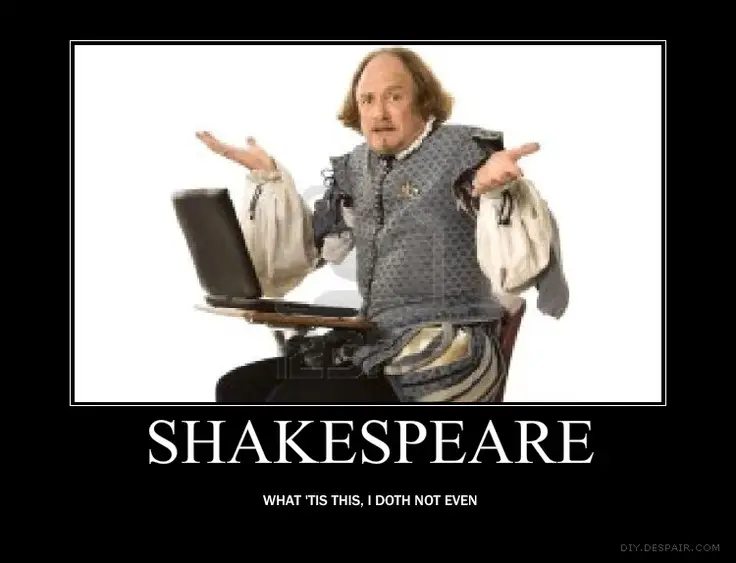

###**Improvement**

---


 Because this model only looked at one play for each playwright, I can see how it would struggle with other types of plays, like tragedies or historical works, which might expand on a different vocaulary and word combinations than a comedy. Even with comedies, only having such a limited source of words and word combinations could pose a problem. In my testing with random phrases and acts from "Merchant of Venice", 
the model would routinely consider phrases or sections as belonging to John Fletcher. 

I have to wonder if adding plays of multiple genres would increase the accuracy, or if adding more works (both comedy and otherwise) would be better. I would guess that vocabulary plays a part, but how they use the words might be more pertinant (think bigrams). 


###**Adaptation**

---

I wonder if we could hook this model up into a function that would churn through plays line by line (or chunks of a given size) to automate the analysis and return info on the authorship prediction for various parts of the play, or even the play as a whole. 

I would like to explore more plays from Shakespeare and see how his own style changed over the course of his career and how that might affect the model. Furthermore, I would love to try the modeling again comparing the three authors (or maybe just two), but include two or more of their works rather than just one. I feel this would expand the vocabulary, but also give a more well-rounded view of their usual style.


###**Other Uses**
---

I would like to see if there is an easy way to adjust the input training/testing dataset that would allow for the model to test other authors of other works of writing. Outside of academic and literature conservation, this could be used to help solve court cases for copyright, identify ghost writers or true authors of books written by pen names. 


I want to thank you for taking the time to read through this, and I hope it helped inform and awaken your curiosity!